<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

In [2]:
# вывод до двух знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

Загрузка данных

In [3]:
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Обзор датасета

In [4]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


* Представлены данные за 5 месяцев 2018 года
* Отсутствуют пропуски

Проверка на последовательность

In [6]:
df_taxi.index.is_monotonic

True

Ресемплирование по часу

In [7]:
df_taxi = df_taxi.resample('1H').sum()

In [8]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проведена промежуточная подготовка данных

## Анализ

Обзор количества заказов такси

<AxesSubplot:>

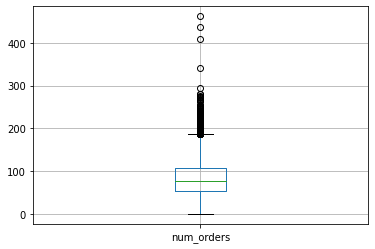

In [9]:
df_taxi.boxplot(['num_orders'])

In [10]:
df_taxi.describe()

,num_orders
count,"4,416.00"
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


**Обзор тренда и сезонности**

Декомпозиция

In [11]:
decompose = seasonal_decompose(df_taxi)

<AxesSubplot:title={'center':'Тренд за весь период'}, xlabel='datetime'>

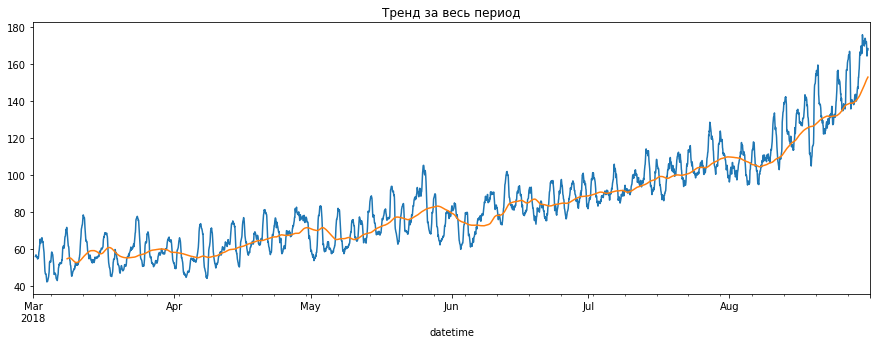

In [12]:

decompose.trend.plot(ax=plt.gca(),figsize=(15, 5))
decompose.trend.rolling(24*7).mean().plot(ax=plt.gca(),figsize=(15, 5),
                                          title = 'Тренд за весь период')

Внутридневная cезонность

<AxesSubplot:title={'center':'Cезонность внутри дня'}, xlabel='datetime'>

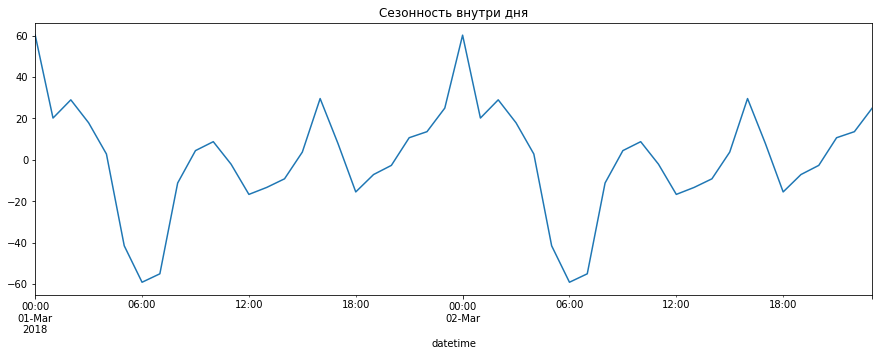

In [13]:
decompose.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(),figsize=(15, 5),
                                                  title = 'Cезонность внутри дня')


Наблюдается:
* Тренд на рост популяности перевозок в течении года, возможно по причине роста популярности такси, роста авиа перевозок
* Цикличность перевозок в течении дня с пиковыми значениями  ночью, возможно причина в труднодоступности другого транспорта в это время


## Обучение

**Выделение  признаков**

Функция для выделения наиболее важных признаков 

In [14]:
def make_features(df, max_lag, rolling_mean_size):

    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


Генерация признаков

In [15]:
make_features(df_taxi, 1, 24)

Удаление полученных пропусков

In [16]:
df_taxi = df_taxi.dropna()

Сплитирование

In [17]:
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)

Получение обучающих и целевых  признаков

In [102]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

**Поиск модели**

Catboost

In [103]:
params = {
#             'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
             'depth':[6,8]
            }

tscv = TimeSeriesSplit(n_splits=2)

grid_cat = GridSearchCV(CatBoostRegressor(random_state = 12345), 
            params, cv=tscv,scoring='neg_mean_squared_error')

In [104]:
grid_cat.fit(train_features,train_target)

Learning rate set to 0.042769
0:	learn: 29.7406353	total: 871us	remaining: 871ms
1:	learn: 29.2532106	total: 1.71ms	remaining: 852ms
2:	learn: 28.7705982	total: 2.57ms	remaining: 855ms
3:	learn: 28.4154187	total: 3.24ms	remaining: 807ms
4:	learn: 28.0406477	total: 4.02ms	remaining: 801ms
5:	learn: 27.7097807	total: 4.75ms	remaining: 787ms
6:	learn: 27.3518108	total: 5.47ms	remaining: 776ms
7:	learn: 26.9937366	total: 6.18ms	remaining: 766ms
8:	learn: 26.6267259	total: 6.92ms	remaining: 762ms
9:	learn: 26.2256658	total: 7.63ms	remaining: 756ms
10:	learn: 25.8857390	total: 8.38ms	remaining: 753ms
11:	learn: 25.5540978	total: 9.1ms	remaining: 749ms
12:	learn: 25.2910324	total: 9.94ms	remaining: 754ms
13:	learn: 25.0529592	total: 10.7ms	remaining: 754ms
14:	learn: 24.7917503	total: 11.4ms	remaining: 748ms
15:	learn: 24.5463891	total: 12.1ms	remaining: 744ms
16:	learn: 24.3116847	total: 13ms	remaining: 750ms
17:	learn: 24.1126958	total: 13.7ms	remaining: 747ms
18:	learn: 23.8480694	total: 1

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f17f5f8e970>,
             param_grid={'depth': [6, 8]}, scoring='neg_mean_squared_error')

In [105]:
(grid_cat.best_score_*-1)**0.5

32.16093323761044

In [106]:
parameters = {
#     'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
#      'n_estimators': [5,8,10,40,30,50,100],
    'max_depth': [6,8]  
            }

grid_lgbm = GridSearchCV(LGBMRegressor(), parameters, cv=tscv, scoring='neg_mean_squared_error')


In [107]:
grid_lgbm.fit(train_features,train_target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=LGBMRegressor(), param_grid={'max_depth': [6, 8]},
             scoring='neg_mean_squared_error')

Метрика RMSE моделей

In [108]:
df_characteristic_models = pd.DataFrame({'RMSE' : [(grid_cat.best_score_*-1)**0.5 ,
                                                   (grid_lgbm.best_score_*-1)**0.5] },
                                    index = ['CatBoost','LGBM'])
df_characteristic_models

,RMSE
CatBoost,32.16
LGBM,30.03


In [109]:
print('Лучшая модель по метрике RMSE:',df_characteristic_models.idxmin())

Лучшая модель по метрике RMSE: RMSE    LGBM
dtype: object


Из двух бустинговых моделей выбираем лучшую

## Тестирование

**Итоговое тестирование выбранной модели**

In [110]:
predictions_test = grid_lgbm.best_estimator_.predict(test_features)
rmse_best_model = mean_squared_error(test_target,predictions_test)**0.5
print('Метрика качества rmse  на тесте, количество заказов:',rmse_best_model)

Метрика качества rmse  на тесте, количество заказов: 41.43554414531218


**Проверка на адекватность**

In [111]:
dummy_reg = DummyRegressor(strategy = 'mean')

dummy_reg.fit(train_features,train_target) 
dummy_predictions = dummy_reg.predict(test_features)
rmse_dummy = mean_squared_error(test_target,dummy_predictions)**0.5

print('Метрика rmse для константной модели :', rmse_dummy)

Метрика rmse для константной модели : 84.68768287118466


In [112]:
pd.DataFrame({'RMSE' : [rmse_best_model ,rmse_dummy] },
              index = ['LightGBM','Const_model'])

,RMSE
LightGBM,41.44
Const_model,84.69


В соответствии с заданием получена модель c метрикой RMSE не хуже требуемой и лучше константной модели